<center><img src=https://automatants.cs-campus.fr/images/logo_mini.png width="150">


# TP Réseaux de Neurones

La formation théorique c'est bien rigolo, mais maintenant à vous de jouer ! Aujourd'hui on crée notre première IA de nos mains qui va détecter des chiffres manuscrits !

**Si vous bloquez sur la moindre chose, n'hésitez pas à faire appel à nous, on est là pour ça**

**PS : tout le texte précédé d'un "#" correspond à une case à compléter/modifier**

##Import des librairies

Commençons par importer numpy, matplotlib.pyplot, torch, torch.nn (qu'on nommera nn) et torchvision

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn

##Téléchargement du Dataset

Le premier dataset sur lequel on va entraîner un réseau de neurones est MNIST. Ce sont 60 000 images de chiffres de 0 à 9 en noir et blanc avec leur catégorie/label associé. Elles sont de taille 28x28 et de pixels à valeurs dans [0,255].

<center><img src=https://production-media.paperswithcode.com/datasets/MNIST-0000000001-2e09631a_09liOmx.jpg width="300">

Le code pour télécharger le dataser est déjà fourni. Les images sont normalisées entre 0 et 1 pour votre plus grand plaisir. Il suffit d'exécuter le code fourni

In [2]:
### Load dataset
dataloader = torchvision.datasets.MNIST(root = "", download=True)
train_size = len(dataloader) * 0.8

X = np.empty((len(dataloader), 28,28))
Y = np.empty(len(dataloader))

for i, (image, label) in enumerate(dataloader):
    X[i] = image
    Y[i] = label

X = X / 255

X_train = X[:int(train_size)]
Y_train = Y[:int(train_size)]

X_test = X[int(train_size):]
Y_test = Y[int(train_size):]

print("Donwloaded Mnist Dataset")
print("Dataset size : ", len(dataloader))
print(f"Training using {len(X_train)} examples")
print(f"Testing using {len(X_test)} examples")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5441315.00it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159123.59it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1505486.40it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5825849.78it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Donwloaded Mnist Dataset
Dataset size :  60000
Training using 48000 examples
Testing using 12000 examples


Affichons quelques images du Dataset pour y voir plus clair

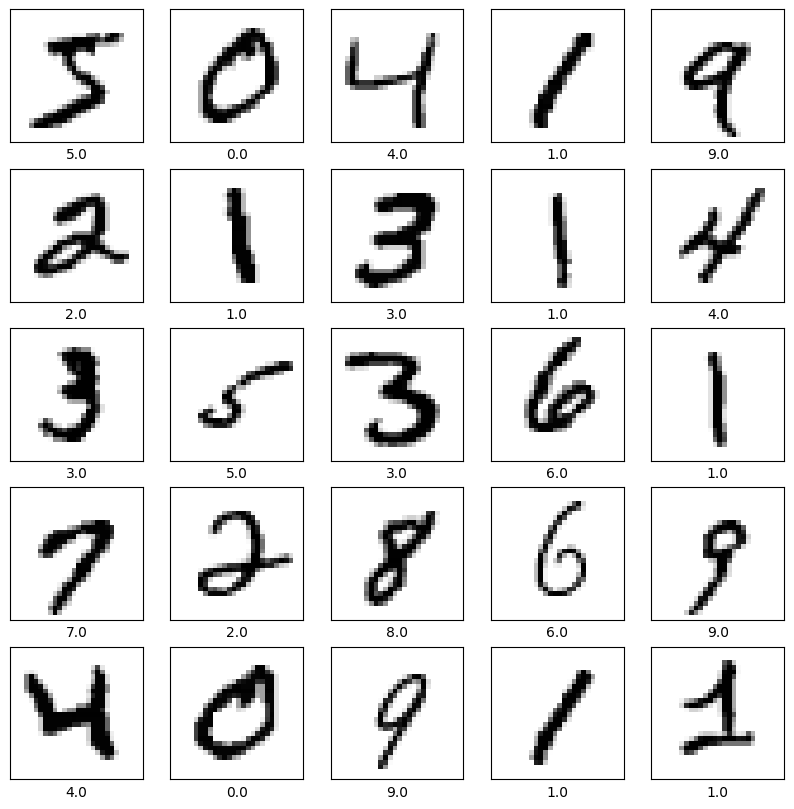

In [3]:
### Display data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])

Au final qu'avons nous devons nous ? On a à disposition `X_train`, `Y_train`, `X_test`, `Y_test`
Commençons par `X_train` et `X_test`

In [4]:
X_train.shape, X_test.shape

((48000, 28, 28), (12000, 28, 28))

Ce qu'on peut remarquer ce que `X_train` contient 48000 examples d'images de taile 28x28
`X_train` contient 1200 images de la même taille

In [5]:
Y_train.shape, Y_test.shape

((48000,), (12000,))

Pour `Y_train` et `Y_test`, nous avons pareil 48000 et 12000 examples mais cette fois on a juste des entiers, cela correspond aux labels. Gardez ça en tête !


##Le Réseau de Neurones

Nous pouvons maintenant commencer le TP ! Comme abordé lors de la première formation, nous allons utiliser les réseaux des neuronnes.

Pour cela, nous allons procéder en 4  étapes :  :
- On va d'abord définir notre réseau
- Puis définir une fonction de perte et une métode d'optimization
- Ensuite on pourra lancer l'entrainement,
- A la fin, on pourra évaluer notre modèle


### Définition du modèle

Nous allons utiliser le module ```Sequential```  de Pytorch. Vous pouvez trouver des informations utiles dans la documentation de Pytorch : https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

Essayons d'utiliser le couches ```nn.Linear``` et ```nn.ReLU``` pour reproduire le réseau que nous avons présenté lors de la formation ! N'oubliez pas d'ajouter la softmax à la fin !


In [6]:
model = nn.Sequential(
    nn.Linear(28*28,16),
    nn.ReLU(),
    nn.Linear(16,16),
    nn.ReLU(),
    nn.Linear(16,10),
    nn.Softmax(1)
)

Pour un petit résumé de notre modèle, appelons le

In [7]:
model

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

### Définition de la fonction de perte et de l'optimizer

On va utiliser la function `MSELoss` et le optimizer `Adam` (vous pouvez trouver de la documentation ici :https://pytorch.org/docs/stable/optim.html ):

In [8]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

###Entraînement : préparation

Avant de lancer la boucle d'entraînement, il faut préparer un peu le terrain :

Rappelez vous que tout d'abord, il fallait "flatten" nos images d'entrée de 28*28 à un gros vecteur de taille 784

Ensuite, vous pouvez remarquer que les labels que nous avons à notre disposition ne sont pas dans le bon format ! Notre réseau sort un vecteur de probbilités, tandis que les labels dans Y_train sont des entiers. Il faut donc transformer les entiers dans des vecteurs de probabilité. Ceci s'appelle l'encodage one-hot.

Exemple :
`5` devient` [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] `



In [9]:
# On commence par changer la structure de X_train. Nous voulons qqch de la forme (N, 28*28)

X_train_flattened = X_train.reshape(-1, 28*28)

In [10]:
# Appliquons maintenant un encodage one-hot de Y_train

Y_train_onehot = np.zeros((Y_train.size, 10 ))
Y_train_onehot[np.arange(len(Y_train)), Y_train.astype(int)] = 1

# Visualisons la forme de cette nouvelle matrice

Y_train_onehot.shape

(48000, 10)

Nous sommes presque prêts à entrainer. La dernière chose qui reste est de transformer nos arrays type numpy aux tensor type Pytorch. L'object tensor est un object spécifique à Pytorch, qui permet de faire des calculs spécifiques au Deep Learning de manière parallèlisée, donc très efficace.
Vous pouvez trouver plus des détails sur internet : https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html

Pour ce qui nous concerne, nous allons manipuler les tensors comme des arrays numpy

Maintenant vous allez entrainer votre modèle sur le dataset qui comporte les images (`X_train`) associées à leur label (`Y_train`). Pour cela on utilise la méthode `model.fit(...)`.

L'argument epochs correspond au nombre de fois où le dataset est présenté au réseau de neurones. Ici mettez entre 1 et 20 epochs.

L'argument validation_data sert à vérifier que votre modèle est bon sur des images qu'il n'a jamais vues (pas utilisées dans l'entrainement), i.e. qu'il n'a pas "appris" le dataset par cœur.

Documentation : https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [11]:
X_train_torch = torch.tensor(X_train_flattened, dtype = torch.float32)
Y_train_onehot_torch = torch.tensor(Y_train_onehot, dtype = torch.float32)

In [12]:
Y_train_onehot_torch.dtype, X_train_torch.dtype,

(torch.float32, torch.float32)

###Entraînement : la boucle

In [13]:
epochs = 50


for _ in range(epochs):
    outputs = model(X_train_torch) # Calculer les predictions du modèle

    loss = loss_function(outputs, Y_train_onehot_torch) # Calculer la loss

    print(loss)

    optimizer.zero_grad() # Mettre les gradients à 0

    loss.backward() # Faire de la backpropagation
    optimizer.step() # Appliquer la formule de mise à jour des poids



tensor(0.0903, grad_fn=<MseLossBackward0>)
tensor(0.0901, grad_fn=<MseLossBackward0>)
tensor(0.0900, grad_fn=<MseLossBackward0>)
tensor(0.0898, grad_fn=<MseLossBackward0>)
tensor(0.0896, grad_fn=<MseLossBackward0>)
tensor(0.0894, grad_fn=<MseLossBackward0>)
tensor(0.0893, grad_fn=<MseLossBackward0>)
tensor(0.0891, grad_fn=<MseLossBackward0>)
tensor(0.0889, grad_fn=<MseLossBackward0>)
tensor(0.0886, grad_fn=<MseLossBackward0>)
tensor(0.0884, grad_fn=<MseLossBackward0>)
tensor(0.0881, grad_fn=<MseLossBackward0>)
tensor(0.0878, grad_fn=<MseLossBackward0>)
tensor(0.0875, grad_fn=<MseLossBackward0>)
tensor(0.0872, grad_fn=<MseLossBackward0>)
tensor(0.0868, grad_fn=<MseLossBackward0>)
tensor(0.0865, grad_fn=<MseLossBackward0>)
tensor(0.0861, grad_fn=<MseLossBackward0>)
tensor(0.0857, grad_fn=<MseLossBackward0>)
tensor(0.0854, grad_fn=<MseLossBackward0>)
tensor(0.0849, grad_fn=<MseLossBackward0>)
tensor(0.0845, grad_fn=<MseLossBackward0>)
tensor(0.0841, grad_fn=<MseLossBackward0>)
tensor(0.08

La loss diminue ! C'est encourageant mais vérifions quand même les performances de notre modèle.

###Evaluation du modèle

Il faut qu'on prépare les `X_test`et `Y_test`de la même manière que pour `X_train`et `Y_train`.
On va quand même se simplifier un peu la vie : plutôt que de mettre nos labels de test en one-hot, on va traduire les prédictions en entier.

In [14]:
# Commencons par le changement de dimension et la transformation en tensor

X_test_flatten = X_test.reshape(-1, 28*28)
X_test_flatten_torch = torch.tensor(X_test_flatten, dtype=torch.float32)


Faisons passer `X_test`à travers le réseau et récupérons la sortie

In [15]:
outputs = model(X_test_flatten_torch)
outputs.shape

torch.Size([12000, 10])

Transformons maintenant les vecteurs de probabilité en entiers

In [16]:
predicted_labels = outputs.argmax(axis=1)

In [17]:
diff = predicted_labels - Y_test
accuracy = len(diff[diff==0]) / len(diff)
accuracy

0.53525

##Améliorations possibles

Bravo ! Vous avez entrainé votre réseau et évalué votre modèle. Nous allons maintenant essayer d'améliorer un peu votre boucle d'entraînement.

D'abord on va entrainer sur plusieurs epochs, donc on veut afficher la loss que périodiqement. Ensuite, il serait intéressant de tracer l'évolution de notre courbe de loss.
Finalement, on pourrait aussi evaluer le modèle à chaque fois qu'on calcule la loss pour avoir une idée plus précise de la performance du modèle

Commençons par les deux premiers points

tensor(0.0682, grad_fn=<MseLossBackward0>)
tensor(0.0613, grad_fn=<MseLossBackward0>)
tensor(0.0539, grad_fn=<MseLossBackward0>)
tensor(0.0469, grad_fn=<MseLossBackward0>)
tensor(0.0407, grad_fn=<MseLossBackward0>)
Fin de l'entraînement


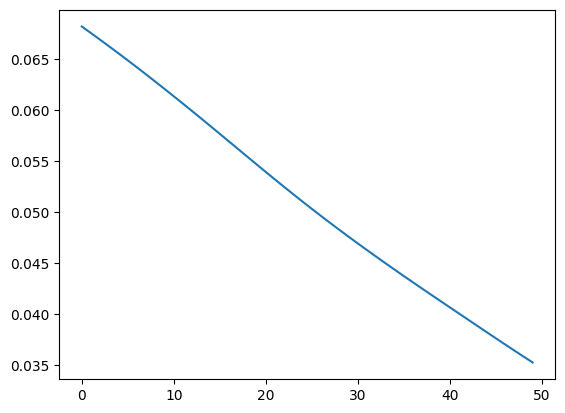

In [18]:
epochs = 50
losses = []

for i in range(epochs):
    outputs = model(X_train_torch) # Calculer les predictions du modèle

    loss = loss_function(outputs, Y_train_onehot_torch) # Calculer la loss
    losses.append(loss.item())

    optimizer.zero_grad() # Mettre les gradients à 0

    loss.backward() # Faire de la backpropagation
    optimizer.step() # Appliquer la formule de mise à jour des poids

    if i % 10 == 0:
        print(loss)


print("Fin de l'entraînement")
plt.plot(losses)


Et maintenant, écrivons une fonction `evaluate_model()` qui permet de calculer la précision du modèle (*accuracy*)

In [19]:
def evaluate_model(model):
    outputs = model(X_test_flatten_torch)
    predicted_labels = outputs.argmax(axis=1)
    diff = predicted_labels - Y_test
    accuracy = len(diff[diff==0]) / len(diff)
    return accuracy

Nous avons tous les éléments maintenant pour créer une bonne boucle d'entraînement. Nous allons redéfinir notre modèle pour initialiser nos poids et commencer table rase (Attention à rédefinir l'optimizer parce que
nous avons des nouveaus paramètres maintenant):

Début de l'entraînement
Epoch 0 | Loss : 0.09015081822872162 | Accuracy : 0.15183333333333332
Epoch 50 | Loss : 0.06679429113864899 | Accuracy : 0.60225
Epoch 100 | Loss : 0.02933279424905777 | Accuracy : 0.8531666666666666
Epoch 150 | Loss : 0.018812373280525208 | Accuracy : 0.8905833333333333
Epoch 200 | Loss : 0.015511885285377502 | Accuracy : 0.9040833333333333
Epoch 250 | Loss : 0.013696746900677681 | Accuracy : 0.91325
Fin de l'entraînement


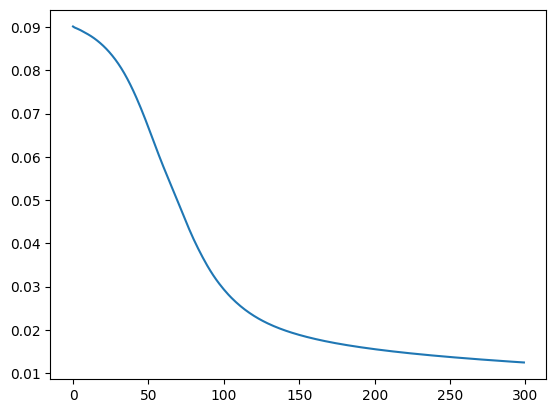

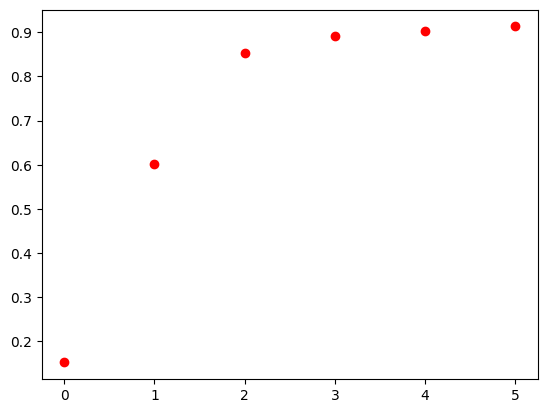

In [20]:
epochs = 300
losses = []
accuracies = []


model = nn.Sequential(
    nn.Linear(28*28,16),
    nn.ReLU(),
    nn.Linear(16,16),
    nn.ReLU(),
    nn.Linear(16,10),
    nn.Softmax(1)
)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Début de l'entraînement")

for i in range(epochs):
    outputs = model(X_train_torch) # Calculer les predictions du modèle

    loss = loss_function(outputs, Y_train_onehot_torch) # Calculer la loss
    losses.append(loss.item())

    optimizer.zero_grad() # Mettre les gradients à 0

    loss.backward() # Faire de la backpropagation
    optimizer.step() # Appliquer la formule de mise à jour des poids

    if i % 50 == 0:
        accuracy = evaluate_model(model)
        print(f"Epoch {i} | Loss : {loss} | Accuracy : {accuracy}")
        accuracies.append(accuracy)




print("Fin de l'entraînement")
plt.plot(losses)
plt.figure()
plt.plot(accuracies, "o", color="red")


##Dans la littérature, la meilleure accuracy est de 99.87%, à vous de le battre !